# **imports and installations**

In [ ]:
!pip install pymupdf azure-identity
!pip install  openai azure-identity
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4


In [ ]:
# NESTED ASYNCIO LOOP NEEDED TO RUN ASYNC IN A NOTEBOOK
import nest_asyncio

nest_asyncio.apply()

# **configuration**

In [ ]:
import openai
import re

# Récupération des variables depuis Colab userdata
from google.colab import userdata

# Configuration des paramètres pour Azure OpenAI
deployment_name="..."
model_name = "..."  # Nom du modèle
openai.api_key = "..."
openai.api_base = "..."
openai.api_version = '...'  # Version de l'API
openai.api_type = 'azure'  # Type de l'API

In [ ]:
import time

def generer_qr(prompt):
    try:
        response = openai.ChatCompletion.create(
            engine="gpt-35-turbo-16k",
            messages=[
                {"role": "system", "content": "You are a knowledgeable assistant that generates "},
                {"role": "user", "content": f""}
            ],
            temperature=0,
            max_tokens=1000,
            frequency_penalty=0,
            presence_penalty=0
        )
        return response['choices'][0]['message']['content']

    except openai.error.RateLimitError as e:
        time.sleep(40)
        return generer_qr(prompt)




In [ ]:
def get_embedding(text):
    response = openai.Embedding.create(
        input=[text],  # API OpenAI attend une liste de textes
        engine="text-embedding-ada-002"
    )
    return response['data'][0]['embedding']

# **text chunking**

In [ ]:
import openai
import re
import fitz  # PyMuPDF
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Récupération des variables depuis Colab userdata
from google.colab import userdata



# Lire le fichier PDF
pdf_file_path = 'rh_policy_entreprise_xxx.pdf'  # Remplacez par le chemin vers votre fichier
doc = fitz.open(pdf_file_path)

# Extraire le texte du PDF
text = ""
for page in doc:
    text += page.get_text()

# Fermer le document PDF
doc.close()

# Diviser le texte en phrases
sentences = re.split(r'(?<=[.?!])\s+', text)

# Créer des embeddings pour chaque phrase
# S'assurer que les phrases sont sous forme de liste de textes
embeddings = []
for sentence in sentences:
    if sentence.strip():  # S'assurer que la phrase n'est pas vide
        embedding = get_embedding(sentence)
        embeddings.append(embedding)

# Calculer les distances cosinus entre les embeddings
def calculate_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        similarity = cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
        distance = 1 - similarity
        distances.append(distance)
    return distances

# Calculer les distances cosinus
distances = calculate_cosine_distances(embeddings)

# Affichage des distances
print(distances)


[0.12618265713932775, 0.15797161533994475, 0.17540724206374714, 0.12849259516395928, 0.1531196557413581, 0.1765500051284875, 0.16242187376070394, 0.17759651253858522, 0.22966627617043445, 0.13606648131090326, 0.19881753471168895, 0.12725937677862975, 0.17399967097151048, 0.13760235457638892, 0.14306518940829216, 0.13153799019045387, 0.17964959291944393, 0.1694681408676837, 0.1949330476218426, 0.09845653140542165, 0.2637681986206786, 0.2605271611183293, 0.12298635547942571, 0.14940756780762532, 0.1644730645030863, 0.2012737722713498, 0.08092036242606859, 0.1682759930703872, 0.13975208109599624, 0.15164566439972016, 0.26931600298537806, 0.27641186428593445, 0.16653556445082718, 0.18593129410091036, 0.14278728952896125, 0.1322317439810733, 0.27997050773929355, 0.2805084150184697, 0.1332053550621316, 0.17276150978902305, 0.10569727195105671, 0.12190814427266672, 0.12615836002110492, 0.11602405662747106, 0.22920370167761828, 0.12302036312183728, 0.25265648892999615, 0.24449087600131603, 0.1

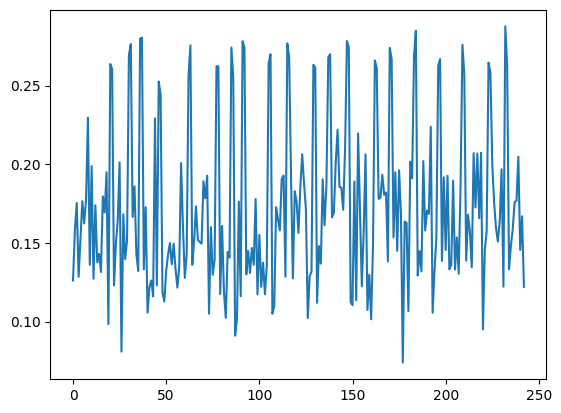

In [ ]:
import matplotlib.pyplot as plt
distances = calculate_cosine_distances(embeddings)
plt.plot(distances);

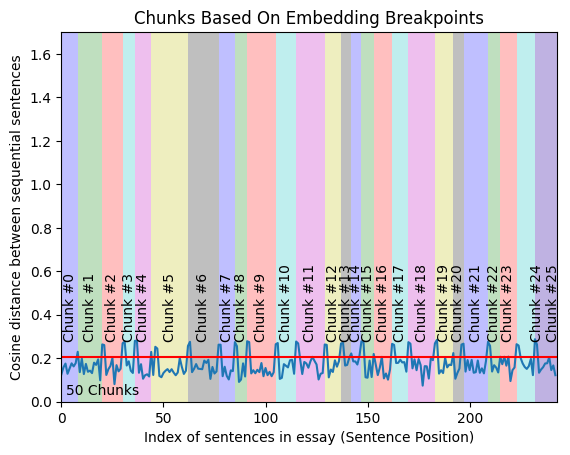

In [ ]:

plt.plot(distances);

y_upper_bound = 1.7
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))
# Déterminer le seuil pour le chunking
breakpoint_distance_threshold = np.percentile(distances, 80)
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');
# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Identifier les indices où les distances dépassent le seuil
indices_above_threshold = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold]
# Filtrer les indices pour ignorer ceux qui sont trop proches les uns des autres
filtered_indices = [indices_above_threshold[0]]  # Démarrer avec le premier indice
min_distance_between_chunks = 5
for i in range(1, len(indices_above_threshold)):
    if indices_above_threshold[i] - filtered_indices[-1] >= min_distance_between_chunks:
        filtered_indices.append(indices_above_threshold[i])
# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# Visualisation avec les indices filtrés
for i, breakpoint_index in enumerate(filtered_indices):
    start_index = 0 if i == 0 else filtered_indices[i - 1]
    end_index = breakpoint_index if i < len(filtered_indices) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# Ajout d'un shading pour le dernier chunk si nécessaire
if filtered_indices:
    last_breakpoint = filtered_indices[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(filtered_indices) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")

plt.show()


In [ ]:
# Regrouper les phrases en chunks en utilisant les indices filtrés
chunks = []
start_index = 0
for index in filtered_indices:
    group = sentences[start_index:index + 1]
    combined_text = ' '.join(group)
    chunks.append(combined_text)
    start_index = index + 1

# Ajouter le dernier groupe s'il reste des phrases
if start_index < len(sentences):
    combined_text = ' '.join(sentences[start_index:])
    chunks.append(combined_text)

# Afficher les chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk #{i + 1}:")
    print(chunk[:200] + "...")
    print("\n")

Chunk #1:
Introduction Générale
Introduction Générale
Présentation de l ’ent repr ise XXX
L’e ntrepris e X XX est une en trep ris e innova nte spécialis ée dans le d oma ine d
e l'automobi le, reconnue po ur so...


Chunk #2:
Collaboration : l’ entreprise XX X  val orise  le t ravail d'équipe  et la col
laboration . Le s employ és sont encouragés à  partager leu rs i dée s et à  tr
availler ensemble pour atteindre des obje...


Chunk #3:
1. Types de Congés
l’entreprise XXX offre plusieurs types de congés afin de répondre aux besoins
divers de ses employés :
Congés Annuels :
Chaque employé à temps plein a droit à 25 jours de congés pay...


Chunk #4:
2. Procédure de Demande de Congés
La demande de congés doit être effectuée selon la procédure suivante :
Soumission de la Demande :
Les employés doivent soumettre une demande de congé par écrit à leur...


Chunk #5:
3. Accumulation et Utilisation des Congés
Accumulation des Congés :
Les jours de congés annuels non utilisés peuvent être repo

In [ ]:
def nettoyer_chunk(chunk):
    """
    Nettoie un chunk de texte en supprimant les caractères indésirables, répétitions,
    et erreurs de formatage pour obtenir un texte lisible et sémantiquement cohérent.
    """
    # Définir le prompt
    prompt = f"""
    Vous êtes un assistant chargé de nettoyer et reformuler des textes extraits de documents PDF.
    Voici un extrait à nettoyer :
    ---
    {chunk}
    ---
    Nettoyez ce texte en supprimant tous les caractères indésirables comme *, #, -, et autres symboles inutiles.
    Reformulez pour corriger les répétitions, améliorer la lisibilité, et garantir que le contenu est sémantiquement clair et fluide.
    Fournissez uniquement le texte propre et bien formaté, sans ajouter de nouvelles informations ni altérer le sens du contenu.
    """
    try:
        # Appel à l'API OpenAI
        response = openai.ChatCompletion.create(
            engine="gpt-35-turbo",  # Modèle utilisé
            messages=[
                {"role": "system", "content": "Vous êtes un assistant spécialisé dans le nettoyage et la reformulation de texte."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=1000,
            frequency_penalty=0,
            presence_penalty=0
        )
        return response['choices'][0]['message']['content']

    except openai.error.RateLimitError:
        # Gestion de l'erreur de limite de taux
        time.sleep(20)
        return nettoyer_chunk(chunk)  # Réessayer avec le même chunk


In [ ]:
cleaned_chunks=[]
for chunk in chunks:
  chunk_propre =nettoyer_chunk(chunk)
  cleaned_chunks.append(chunk_propre)

In [ ]:
import json
chunks_dict = {f"chunk_{i}":   cleaned_chunks[i] for i in range(len( cleaned_chunks))}

# Sauvegarder ce dictionnaire dans un fichier JSON
with open("chunks.json", "w") as file:
    json.dump(chunks_dict, file, indent=4)

print("Les chunks ont été sauvegardés dans 'chunks.json'")

Les chunks ont été sauvegardés dans 'chunks.json'


# **Questions-answers generation**

In [ ]:
import json

answers_concatenated = []
questions = []
answers = []
s=-1
for chunk in cleaned_chunks:
    s+=1
    parsed_result = []
    resultat = generer_qr(chunk)
    print("genrated chunk", s)

    try:
        parsed_result = json.loads(resultat)  # Chargement du JSON
    except json.JSONDecodeError:
        print("Erreur : Le résultat généré n'est pas un JSON valide.", s)

    if isinstance(parsed_result, list) and len(parsed_result) > 0:
        # Extraction des questions et réponses
        chunk_questions = [entry["question"] for entry in parsed_result]
        chunk_answers = [entry["answer"] for entry in parsed_result]

        questions.extend(chunk_questions)
        answers.extend(chunk_answers)
        answers_concatenated.append(chunk_answers)
    else:
        answers_concatenated.append([s])

genrated chunk 0
genrated chunk 1
genrated chunk 2
genrated chunk 3
genrated chunk 4
genrated chunk 5
genrated chunk 6
genrated chunk 7
genrated chunk 8
genrated chunk 9
genrated chunk 10
genrated chunk 11
genrated chunk 12
genrated chunk 13
Erreur : Le résultat généré n'est pas un JSON valide. 13
genrated chunk 14
Erreur : Le résultat généré n'est pas un JSON valide. 14
genrated chunk 15
genrated chunk 16
genrated chunk 17
genrated chunk 18
genrated chunk 19
genrated chunk 20
genrated chunk 21
genrated chunk 22
genrated chunk 23
genrated chunk 24
genrated chunk 25


In [ ]:
len(questions) ==  len(answers)

True

In [ ]:
# Transformation
answers_per_chunk = [[" ".join(chunk)] for chunk in answers_concatenated]

print(answers_per_chunk)

[["L'entreprise XXX est spécialisée dans le domaine de l'automobile. L'entreprise XXX a été fondée en [année de fondation]. Les bureaux principaux de l'entreprise XXX se trouvent à [localisation des bureaux principaux]. La mission de l'entreprise XXX est de fournir des produits et services de haute technologie qui améliorent la performance des véhicules et garantissent la sécurité des utilisateurs. Les valeurs fondamentales de l'entreprise XXX sont l'innovation et la qualité. L'entreprise XXX encourage la créativité et l'innovation à tous les niveaux de l'organisation et investit continuellement dans la recherche et le développement pour offrir des solutions de pointe. L'engagement envers la qualité est au cœur de toutes les activités de l'entreprise XXX. Chaque produit et service de l'entreprise XXX est conçu pour répondre aux standards les plus élevés afin de garantir la satisfaction des clients."], ["L'entreprise XXX valorise le travail d'équipe et la collaboration. L'entreprise XXX

# **Evaluation**

In [ ]:
pip install nltk rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d6ce00ee30a011ff9656affddc2b74156ad2afb433276d60f07b93d1aecb35b3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer


nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Transformation
chunks_listed = [[chunk] for chunk in chunks]
len(chunks_listed)

26

old data

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Example chunks_listed (reference) and answers_per_chunk (candidate)
reference = chunks_listed  # List of reference sentences
candidate = answers_per_chunk  # List of candidate sentences

# Tokenize the reference and candidate
reference_tokenized = [nltk.word_tokenize(ref[0]) for ref in reference]  # ref[0] because each element of reference is a sublist
candidate_tokenized = [nltk.word_tokenize(cand[0]) for cand in candidate]  # cand[0] because each element of candidate is a sublist

# BLEU Score Calculation for each chunk
bleu_scores = []  # List to store BLEU scores
for i in range(len(reference)):
    bleu_score = sentence_bleu([reference_tokenized[i]], candidate_tokenized[i])
    bleu_scores.append(bleu_score)
    print(f"BLEU Score for chunk {i+1} (NLTK): {bleu_score * 100:.2f}")



# ROUGE Score Calculation for each chunk
rouge1_scores = []  # List to store ROUGE-1 F1 scores
rougeL_scores = []  # List to store ROUGE-L F1 scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for i in range(len(reference)):
    scores = scorer.score(reference[i][0], candidate[i][0])  # reference[i][0] and candidate[i][0] because they are sublists
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)
    print(f"ROUGE-1 F1 Score for chunk {i+1}: {scores['rouge1'].fmeasure:.2f}")
    print(f"ROUGE-L F1 Score for chunk {i+1}: {scores['rougeL'].fmeasure:.2f}")

# Calculate the average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu * 100:.2f}")
# Calculate the average ROUGE-1 F1 and ROUGE-L F1 scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)
print(f"Average ROUGE-1 F1 Score: {average_rouge1:.2f}")
print(f"Average ROUGE-L F1 Score: {average_rougeL:.2f}")


BLEU Score for chunk 1 (NLTK): 3.01
BLEU Score for chunk 2 (NLTK): 25.14
BLEU Score for chunk 3 (NLTK): 66.65
BLEU Score for chunk 4 (NLTK): 59.78
BLEU Score for chunk 5 (NLTK): 34.00
BLEU Score for chunk 6 (NLTK): 40.37
BLEU Score for chunk 7 (NLTK): 40.35
BLEU Score for chunk 8 (NLTK): 58.99
BLEU Score for chunk 9 (NLTK): 61.70
BLEU Score for chunk 10 (NLTK): 27.04
BLEU Score for chunk 11 (NLTK): 31.04
BLEU Score for chunk 12 (NLTK): 67.76
BLEU Score for chunk 13 (NLTK): 62.84
BLEU Score for chunk 14 (NLTK): 46.23
BLEU Score for chunk 15 (NLTK): 36.08
BLEU Score for chunk 16 (NLTK): 64.14
BLEU Score for chunk 17 (NLTK): 66.52
BLEU Score for chunk 18 (NLTK): 73.89
BLEU Score for chunk 19 (NLTK): 30.67
BLEU Score for chunk 20 (NLTK): 82.43
BLEU Score for chunk 21 (NLTK): 27.05
BLEU Score for chunk 22 (NLTK): 80.73
BLEU Score for chunk 23 (NLTK): 53.92
BLEU Score for chunk 24 (NLTK): 19.03
BLEU Score for chunk 25 (NLTK): 76.10
BLEU Score for chunk 26 (NLTK): 82.54
ROUGE-1 F1 Score for c

new data

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Example chunks_listed (reference) and answers_per_chunk (candidate)
reference = chunks_listed  # List of reference sentences
candidate = answers_per_chunk  # List of candidate sentences

# Tokenize the reference and candidate
reference_tokenized = [nltk.word_tokenize(ref[0]) for ref in reference]  # ref[0] because each element of reference is a sublist
candidate_tokenized = [nltk.word_tokenize(cand[0]) for cand in candidate]  # cand[0] because each element of candidate is a sublist

# BLEU Score Calculation for each chunk
bleu_scores = []  # List to store BLEU scores
for i in range(len(reference)):
    bleu_score = sentence_bleu([reference_tokenized[i]], candidate_tokenized[i])
    bleu_scores.append(bleu_score)
    print(f"BLEU Score for chunk {i+1} (NLTK): {bleu_score * 100:.2f}")



# ROUGE Score Calculation for each chunk
rouge1_scores = []  # List to store ROUGE-1 F1 scores
rougeL_scores = []  # List to store ROUGE-L F1 scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for i in range(len(reference)):
    scores = scorer.score(reference[i][0], candidate[i][0])  # reference[i][0] and candidate[i][0] because they are sublists
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)
    print(f"ROUGE-1 F1 Score for chunk {i+1}: {scores['rouge1'].fmeasure:.2f}")
    print(f"ROUGE-L F1 Score for chunk {i+1}: {scores['rougeL'].fmeasure:.2f}")

# Calculate the average BLEU score
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu * 100:.2f}")
# Calculate the average ROUGE-1 F1 and ROUGE-L F1 scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)
print(f"Average ROUGE-1 F1 Score: {average_rouge1:.2f}")
print(f"Average ROUGE-L F1 Score: {average_rougeL:.2f}")


BLEU Score for chunk 1 (NLTK): 20.80
BLEU Score for chunk 2 (NLTK): 39.85
BLEU Score for chunk 3 (NLTK): 59.06
BLEU Score for chunk 4 (NLTK): 48.71
BLEU Score for chunk 5 (NLTK): 66.02
BLEU Score for chunk 6 (NLTK): 50.33
BLEU Score for chunk 7 (NLTK): 41.80
BLEU Score for chunk 8 (NLTK): 34.20
BLEU Score for chunk 9 (NLTK): 69.03
BLEU Score for chunk 10 (NLTK): 41.04
BLEU Score for chunk 11 (NLTK): 48.11
BLEU Score for chunk 12 (NLTK): 63.04
BLEU Score for chunk 13 (NLTK): 53.53
BLEU Score for chunk 14 (NLTK): 24.24
BLEU Score for chunk 15 (NLTK): 43.93
BLEU Score for chunk 16 (NLTK): 50.18
BLEU Score for chunk 17 (NLTK): 69.25
BLEU Score for chunk 18 (NLTK): 60.76
BLEU Score for chunk 19 (NLTK): 38.63
BLEU Score for chunk 20 (NLTK): 72.67
BLEU Score for chunk 21 (NLTK): 31.25
BLEU Score for chunk 22 (NLTK): 40.50
BLEU Score for chunk 23 (NLTK): 29.01
BLEU Score for chunk 24 (NLTK): 31.39
BLEU Score for chunk 25 (NLTK): 48.10
BLEU Score for chunk 26 (NLTK): 63.94
ROUGE-1 F1 Score for 

# **structuration des données**

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
dialogues = []
for q, a in zip(questions, answers):
    dialogue = f"### Human: {q}\n### Assistant: {a}"
    dialogues.append({'text': dialogue})

In [ ]:
from datasets import Dataset, DatasetDict
dataset = Dataset.from_list(dialogues)

In [ ]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

ds = DatasetDict({
    'train': dataset_split['train'],
    'test': dataset_split['test']
})

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 107
    })
    test: Dataset({
        features: ['text'],
        num_rows: 27
    })
})


In [ ]:
print(ds['train'][0])

{'text': "### Human: Que comprend l'auto-évaluation dans le processus d'évaluation annuelle de l'entreprise XXX?\n### Assistant: L'auto-évaluation dans le processus d'évaluation annuelle de l'entreprise XXX permet à chaque employé de réfléchir à ses réalisations, ses défis et ses progrès par rapport aux objectifs fixés."}


** Saving all questions and responses into a json file**

In [ ]:
import json

output_file = "dataset.json"

with open(output_file, "w") as f:
    for split_name, split_data in ds.items():
        for example in split_data:
            entry = {"human": example["text"].split("### Human: ")[1].split("\n### Assistant: ")[0],
                     "assistant": example["text"].split("### Assistant: ")[1]}
            f.write(json.dumps(entry) + "\n")

from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>